In [1]:
# For IceCube Data analysis .... 
# This is for Data analysis the example basic is for Sensitivity 


In [2]:
# imports
from constants import pdm_constants as const
from config import config
from pone_aeff import Aeff
from dm2nu import DM2Nu
from atm_shower import Atm_Shower
from detectors import Detector
import numpy as np
import matplotlib.pyplot as plt
from limit_calc import Limits
from bkgrd_calc import Background
from signal_calc import Signal
from pdm import PDM
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2
from scipy.stats import *
from scipy import optimize
from scipy.odr import ODR, Model, Data, RealData
from pylab import *
from pone_aeff import Aeff
import pickle
import csv
from scipy.stats import poisson
from matplotlib import rc
from CL_s import *

In [3]:
# picture path
PICS = '../pics/'
name=[r'$\nu_{\mu}$', r"$\nu_e$", r"$\nu_{\tau}$"]  # ,r'$\nu_{e}$',r'$\nu_{\tau}$'
# Plotting standards
std_size = 6.  # Size of the plot
fontsize = 15.  # Fontsize in the plot
lw=0.5  # Linewidth
h_length=0.5  # Handle length for the legends
export_dpi = 500  # Dpi for the image export
color_pone='#7570b3'
color_ice='#e7298a'
color_combined='#33a02c'
color_thermal='#1f78b4'
color_unitary='k'
color_4='#1b9e77'
color_6='#d95f02'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [4]:
surface_fluxe = pickle.load(open("../data/" +
                                                   "surf_store_v1.p", "rb"))

In [5]:
projection_ice = pickle.load(open('../data/background_ice.pkl','rb'))
#signal_ice =pickle.load(open("../data/limits_signal_IceCube.pkl", "rb"))


projection_pone = pickle.load(open('../data/background_pone_unsm.pkl','rb'))

In [6]:
len(projection_pone['numu'])

121

In [7]:
#for i in projection_ice.keys():
#    projection_ice[i]=np.sum(projection_ice[i], axis=0)

In [8]:
e_grid = surface_fluxe[0][0]
e_width = surface_fluxe[0][1]
def width2grid(a: np.array):
    m_a = []
    for i, e in enumerate(a):
        if i == 0:
            m_a.append(e)
        elif i==len(a)-1:
            print(i)
            break
        else:
            m_a.append((a[i] + a[i+1]) / 2)

    return np.array(m_a)

In [9]:
e_grid_bin = width2grid(e_grid)

120


In [10]:
def astro_flux():
     res = 1.66 * (e_grid / 1e5)**(-2.6) * 1e-18  # Custom
     return res

In [11]:
def ice_parser(filename):
    
        store = []
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row_num, row in enumerate(reader):
                if row_num == 0:
                    continue
                store.append(row[0].split())
        store = np.array(store, dtype=float)

        return store

In [12]:


def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic



In [13]:
bkgrd_ice_data = [
                        '../data/icecube_10year_ps/events/IC40_exp.csv',
                        '../data/icecube_10year_ps/events/IC59_exp.csv',
                        '../data/icecube_10year_ps/events/IC79_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_I_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_II_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_III_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_V_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
                    ]
bkgrd_ice_dic = {
                        0: ice_parser(bkgrd_ice_data[0]),
                        1: ice_parser(bkgrd_ice_data[1]),
                        2: ice_parser(bkgrd_ice_data[2]),
                        3: ice_parser(bkgrd_ice_data[3]),
                        4: ice_parser(bkgrd_ice_data[4]),
                        5: ice_parser(bkgrd_ice_data[5]),
                        6: ice_parser(bkgrd_ice_data[6]),
                        7: ice_parser(bkgrd_ice_data[7]),
                        8: ice_parser(bkgrd_ice_data[8]),
                        9: ice_parser(bkgrd_ice_data[9]),
                    }

In [14]:
ice_tmp_data_dic = data_filter(bkgrd_ice_dic, [2,8], [0,180], range(0,10))

In [15]:
ice_data_dic = {}

for i in bkgrd_ice_dic.keys():
    tmp_hist_data, bins_edge = np.histogram(ice_tmp_data_dic[i][:,1], bins=np.log10(e_grid) )
    ice_data_dic[i] = tmp_hist_data

In [16]:
ice_d = []
for i in range(0,10):
    ice_d.append(ice_data_dic[i])
ice_d = np.sum(ice_d, axis=0)

In [17]:
# projection_ice["numu"] = np.sum(projection_ice["numu"][3:],axis=0)

In [18]:
# q_single_b(projection_ice["numu"][45:70], ice_d[45:70])

In [19]:
l = range(0,10)

In [20]:
np.array(l)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
def _find_nearest(array: np.array, value: float):
    
    """ Returns: index of the nearest vlaue of an array to the given number
    --------------
    idx :  float
    """
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [22]:
_find_nearest(e_grid, 5e2), _find_nearest(e_grid, 1e6)

(37, 70)

In [23]:
np.log10(ice_data_dic[1][38:67])

array([2.31806333, 2.8286599 , 3.3960249 , 3.67292869, 3.80875097,
       3.85144181, 3.74849813, 3.69609416, 3.47567119, 3.31302311,
       3.17609126, 2.97358962, 2.92116605, 2.6919651 , 2.67851838,
       2.58433122, 2.29885308, 2.24797327, 2.08635983, 1.96848295,
       1.93449845, 1.65321251, 1.61278386, 1.34242268, 1.2787536 ,
       1.        , 0.60205999, 0.        , 0.77815125])

In [24]:
def fit_fun_gamma(A, E, gamma, phi_0):
    return (A*(E)**(-gamma) + phi_0)



In [25]:
para = {}
p = {}

para_fun = {}
p_fun = {}
phi_fits = {}
new_phi = {}
phi_fun = {}
# 5.11951803,   15.42169565, 2821.23529455]
# [ 1.56906855e-01, -2.63388990e+02,  1.01791398e+00]
#
for i in range(0,9):
    new_phi[i] = []
    phi_fun[i] = []
    phi_fits[i] = []
    if i==0:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[40:66], np.log10(ice_data_dic[i][40:66]),
                                        method='dogbox')
        para[i] = t_para
        p[i]= _p

    elif i==1:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[40:67], np.log10(ice_data_dic[i][40:67]))
        para[i] = t_para
        p[i]= _p

    elif i==2:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[38:60], np.log10(ice_data_dic[i][38:60]))
        para[i] = t_para
        p[i]= _p

    else:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[38:57], np.log10(ice_data_dic[i][38:57]), method='dogbox')
        para[i] = t_para
        p[i]= _p

    phi_fits[i].extend(fit_phi(e_grid, *para[i]))
    new_phi[i].extend(10**(fit_phi(e_grid, *para[i])))

    # phi_fun[i].extend((fit_fun_gamma(e_grid, *para_fun[i])))

/home/kruteesh/miniconda3/envs/pdm/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/tmp/ipykernel_16869/1548751189.py:36: RuntimeWarning: invalid value encountered in log10
  return np.log10(spl_phi(E + E_0 )*A + b)
/tmp/ipykernel_16869/1548751189.py:44: RuntimeWarning: invalid value encountered in log10
  return np.log10(spl_phi(E + E_0 )*A + b)


In [26]:
para, para_fun

({0: array([   0.58195544, -377.09055233,    0.90381744]),
  1: array([   0.57095728, -396.87090537,    6.34579318]),
  2: array([ 1.79876222e-01, -2.60826650e+02,  7.10855290e+01]),
  3: array([   2.40665504, 1393.15530721,   -1.46548055]),
  4: array([   2.79709453, 1378.9040799 ,   -3.76694495]),
  5: array([   2.86761448, 1406.89317225,   -4.94606488]),
  6: array([2.54120355e+00, 1.29939162e+03, 9.25593761e-01]),
  7: array([   2.2285067 , 1143.13585729,   -3.81331981]),
  8: array([ 2.60700877e+00,  1.32356557e+03, -4.63049346e-01])},
 {})

In [27]:
phi_fit = []
for i in range(0,9):
     phi_fit.append(new_phi[i])

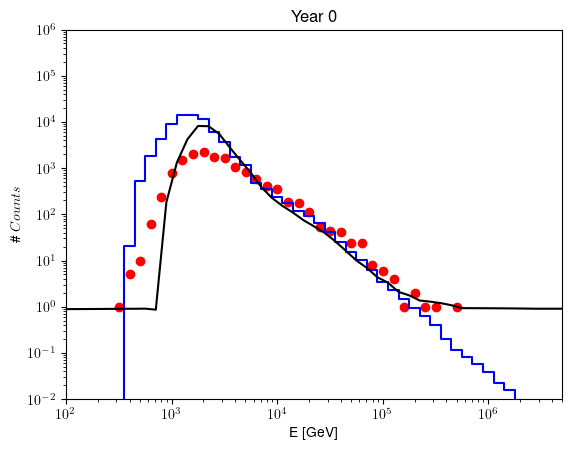

In [28]:
for i in range(0, 9):
    plt.figure()
    plt.title('Year %d ' % (i))
    plt.step(e_grid, projection_ice['numu'][i], color='b' )
    plt.plot(e_grid, new_phi[i], color='k')
    #plt.plot(e_grid, phi_fun[i], color='g')
    #plt.step(e_grid, projection_pone['numu'][i], color='k' )
    plt.scatter(e_grid_bin, ice_data_dic[i], color='r')
    #plt.plot(e_grid[32:50], ice_data_dic[i][32:50], color='g')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-2,1e6)
    plt.xlim(1e2,5e6)
    plt.xlabel(r'E [GeV] ')
    plt.ylabel(r'\# $Counts$')
#    plt.savefig("../pics/IceCube_counts_%d.png" % (i), facecolor="white")
    break


In [29]:
spl_phi = UnivariateSpline(e_grid, np.sum(np.array(projection_ice['numu'][3:]), axis=0), k=1, s=0) # The projection_ice / ice_dneeds to be changed to total sum ...... 
np.log10(ice_d)[np.log10(ice_d) == -np.inf] = 0
def fit_phi(E, A, E_0):
          return (A * spl_phi(E + E_0 ))
t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[38:70], np.nan_to_num((ice_d))[38:70],[   1.67881964, 1140.13585799], bounds=[[1, 20],[3, 3000]], method='dogbox')

/tmp/ipykernel_16869/1771748151.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(ice_d)[np.log10(ice_d) == -np.inf] = 0


In [30]:
t_para # array([2.20735973e+00, 2.91299035e+03]) for 0-9 years 
# array([   1.67881964, 1143.13585799,    2.        ]) for 3-9 years

array([   1.68929581, 1143.13585616])

In [31]:
def odr_fit_phi(A, x):
    return (A[0] * spl_phi(x + A[1] ) + A[2])


In [32]:
odr_model = Model(odr_fit_phi)
odr_data = RealData(e_grid[36:71], ice_d[36:71])


In [33]:
odr_fit = ODR(odr_data, odr_model, beta0=[2.00735973e+00, 2.91299035e+03, 1])

In [34]:
odr_fit.set_job(fit_type=0)

In [35]:
odr_out = odr_fit.run()

In [36]:
odr_out.beta


array([   4.20067058, 1735.71864707,  111.60970524])

In [37]:
fit_phi_odr = odr_fit_phi(odr_out.beta, e_grid_bin)

In [38]:
ice_d_spl = UnivariateSpline(e_grid_bin, ice_d, k=1, s=0)(e_grid)

In [39]:
ice_d_spl[46:67], ice_d[46:70]

(array([2.01460287e+04, 1.16888110e+04, 7.54484406e+03, 4.90509342e+03,
        3.31603912e+03, 2.33876199e+03, 1.46352555e+03, 1.15625272e+03,
        7.53940458e+02, 4.69335889e+02, 3.53731163e+02, 2.57715359e+02,
        1.88849777e+02, 1.27043424e+02, 7.26877396e+01, 5.49327908e+01,
        3.56877396e+01, 2.28023629e+01, 1.27865582e+01, 9.11462327e+00,
        8.44268837e+00]),
 array([13966,  8822,  5937,  3606,  2951,  1568,  1332,   935,   526,
          398,   298,   207,   166,    78,    66,    41,    29,    15,
           10,     8,     9,     2,     1,     0]))

In [40]:
print("low = %.1e, high = %.1e," % (e_grid[46], e_grid[70]))

low = 3.5e+03, high = 8.9e+05,


In [41]:
aa= np.array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,])

In [42]:
e_grid[50]

8912.509381337459

In [43]:
p_CL_b = poisson.pmf(ice_d[32:], fit_phi_odr[32:]) # q_single_b from CL_s
p_CL_ob = poisson.pmf(ice_d[32:], ice_d[32:])

In [44]:
p_CL_b, p_CL_ob

(array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.89731276e-049,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 9.41279137e-219,
        5.49791926e-144, 5.36912217e-058, 2.17376521e-169, 2.51526578e-040,
        2.03391080e-100, 1.86534775e-070, 2.02721246e-020, 1.19919611e-017,
        7.65307728e-012, 2.72765151e-004, 8.99425748e-003, 4.75457286e-008,
        1.24457110e-009, 1.48359953e-017, 6.36314649e-023, 2.67587246e-032,
        1.72612166e-036, 2.88176504e-038, 6.38356842e-037, 7.53367593e-046,
        1.78721536e-047, 2.03099107e-049, 1.49577678e-045, 2.62597531e-049,
        3.16609179e-047, 2.97922184e-049, 3.10229757e-049, 3.18426420e-049,
        3.23398211e-049, 3.27822254e-049, 3.30824120e-049, 3.32749021e-049,
        3.34244577e-049, 3.35238219e-049, 3.36084409e-049, 3.36677675e-049,
        3.36

In [45]:
(q_single_b(fit_phi_odr[51:71], ice_d[50:70]))


array([0.00000000e+000, 5.37200268e-173, 3.83901576e-211, 5.63431020e-150,
       3.84924047e-049, 1.51368071e-034, 5.02241569e-019, 1.61494192e-005,
       2.82992467e-002, 2.19472640e-005, 2.42813590e-007, 2.02547316e-015,
       4.34083763e-021, 9.26817111e-031, 3.30883820e-035, 3.63934026e-037,
       7.25703466e-036, 3.70960383e-045, 6.18982545e-047, 2.38669061e-049])

In [46]:
print('logical low E cutoff from above = %.1e' % (e_grid[52]))

logical low E cutoff from above = 1.4e+04


In [47]:
mass_grid = enumerate(np.logspace(2, 6, 9))
sv_grid = enumerate(np.logspace(-26, -21, 9))
# print("sv_index = %f, mass_index = %f" % (s, m))
CLs_, prob = CL_scan(signal_ice[:,:,51:71], fit_phi_odr[51:71], ice_d[50:70], sv_grid, mass_grid, sample_count=10000)
print("CLs")
print(CLs_)
print("prob Mat")
print(prob)


NameError: name 'signal_ice' is not defined

In [ ]:
figure, ax1 = plt.subplots(1,1,figsize=(std_size,std_size), sharex=True) 
ax1.set_title(r'10 Years IceCube ', fontsize=fontsize)
ax1.scatter(e_grid_bin, ice_d, color=color_ice, label="Data")

ax1.set_xscale('log')
ax1.set_yscale("log")
ax1.set_xlim(0.8e3,1e6)

ax1.set_ylim(1e0,2e5)
ax1.set_xlabel(r'$\log_{10}$ ( $E$ / $ \textrm{GeV} )$ ', fontsize=fontsize)

ax1.set_ylabel(r'$\#$ $\textrm{Counts}$', fontsize=fontsize)

ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')

figure.savefig(PICS + "background_IceCube_10"+".png",
               bbox_inches='tight', dpi=export_dpi, facecolor='white')


: 

In [ ]:
pickle.dump([e_grid_bin, ice_d], open('../data/background_ice_10.pkl', 'wb'))

: 

In [ ]:
odr_fit.restart()

: 

This is the Poissonian CL

In [ ]:
tmp_pois = np.abs(ice_d[35:70] - fit_phi(e_grid_bin, *t_para)[35:70]) / fit_phi(e_grid_bin, *t_para)[35:70]**(1/2)
tmp_odr = np.abs(ice_d[35:70] - fit_phi_odr[35:70]) / fit_phi_odr[35:70]**(1/2)

: 

In [ ]:

e_grid[46]

: 

In [ ]:
_find_nearest(e_grid, 3000)

: 

In [ ]:
odr_p = (poisson.pmf(ice_d[46:], fit_phi_odr[46:]))
odr_d = poisson.pmf(ice_d[30:70], ice_d[30:70])
p_p = (poisson.pmf(ice_d[50:70], fit_phi(e_grid_bin, *t_para)[50:70]))
p_d = poisson.pmf(ice_d[0:80], ice_d[0:80])

: 

In [ ]:
odr_d

: 

In [ ]:
p_d

: 

In [ ]:
ice_d

: 

In [ ]:
p_r = odr_p / p_d

: 

In [ ]:
p_r

: 

In [ ]:
np.prod(p_r)

: 

In [ ]:
tmp_pois ##### array([8.68845737e+04, 5.91198556e+04, 3.83521927e+04, 2.37712564e+04,
                     #1.37239028e+04, 1.05008990e+04, 5.63606489e+03, 3.35222694e+03,
                     #2.11754555e+03, 1.19897309e+03, 8.90809383e+02, 4.23990583e+02,
                     #3.24261426e+02, 1.73625826e+02, 1.13772767e+02, 5.58985893e+01,
                     #3.59436341e+01, 1.69781649e+01, 1.09905348e+01, 5.99842260e+00,
                     #3.00049494e+00, 1.00029681e+00, 1.00029661e+00, 9.99901219e-01,
                     #1.00029605e+00, 1.00029566e+00, 9.99901616e-01, 9.99901822e-01,
                     #9.99902081e-01, 9.99902408e-01, 9.99902819e-01, 9.99903337e-01,
                     #1.92032189e-04, 9.99904809e-01, 9.99905842e-01, 9.99907142e-01,
                     #9.99908779e-01, 9.99910840e-01, 9.99913435e-01, 9.99916701e-01] for 3-9 years.p

: 

In [ ]:
tmp_ice_counter = 0
tmp_pro_counter = 0
for y in range(0,9):
    tmp_ice_counter += np.sum(ice_data_dic[y][40:])
    tmp_pro_counter += np.sum(np.nan_to_num(phi_fit[y][40:]))
    print("Year = %d, Data sum = %.5e, Projection sum = %.5e" % (y+1, np.sum(ice_data_dic[y][40:]),
           np.sum(np.nan_to_num(phi_fit[y][40:]))))
print('Ice Counter =  %.5e, pro counter = %.5e ' %(tmp_ice_counter, tmp_pro_counter))

: 

This is the chi2 CL


In [ ]:
CL_data_b = {}
tmp_cl = {}
for y in range(0,9):
  tmp_=np.sum(np.nan_to_num(np.abs(np.array(ice_data_dic[y][48:70] - phi_fit[y][48:70])) / np.nan_to_num(np.array(phi_fit[y][48:70]))**(1/2) ))
  tmp_cl[y] =chi2.sf(tmp_**2, 2)
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 / 
                                         np.nan_to_num(phi_fit[y])[48:-1])))            
  print(k)
  CL_data_b[y] = chi2.sf(k, 2)
# np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][38:] - np.nan_to_num(phi_fit[y])[38:-1])**2 / np.nan_to_num(phi_fit[y])[38:-1]))

: 

In [ ]:
chi2.sf(53973.1535298152, 2)

: 

In [ ]:
CL_data_b

: 

In [ ]:
CL_data_b, np.sum(np.nan_to_num((ice_d - np.sum(phi_fit, axis=0)[:-1])**2 / np.sum(phi_fit, axis=0)[:-1]))

: 

: 